# Chapter 5.4 Evaluating Classification Models

The only difference between evaluating regression models and evaluating classification models is the choice of error metric. Everything else is the same once you choose an error metric; you can calculate the metric on the training data or on a test set. You can also do cross validation.

In this section, we demonstrate how to calculate the metrics on the training data, but you can calculate the same metrics on the test set if you first split your data into a training and a test set, like we did in the previous section.

First, let's train a $9$-nearest neighbors model on the wine data to predict the wine color and get the predictions on the training data, just to use as an example. The following code is copied from Section 5.1.

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

pd.options.display.max_rows = 5

reds = pd.read_csv("../data/wines/reds.csv", sep=";")
whites = pd.read_csv("../data/wines/whites.csv", sep=";")

reds["color"] = "red"
whites["color"] = "white"

wines = pd.concat([reds, whites], ignore_index=True)
wines

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
...             ...               ...          ...             ...        ...   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
...                   ...                   ...      ...   ...        ...   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  color  
0         9.4        5    red  
1         9.8        5    red  
...       ...      ...    ...  
6495     12.8        7  white  
6496     11.8        6  white  

[6497 rows x 13 columns]

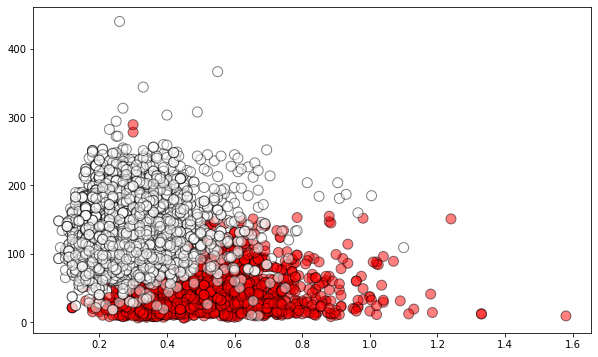

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(x=wines["volatile acidity"], y=wines["total sulfur dioxide"],s=100, alpha=0.5, c=wines["color"], edgecolors="black")

plt.show()

In [7]:
X_train = wines[["volatile acidity", "total sulfur dioxide"]]
y_train = wines["color"]

X_train_std = (X_train - X_train.mean()) / X_train.std()

In [8]:
def get_9NN_prediction(obs):
    """Given a new observation (standardized), find its
       9-nearest neighbors in the training data and 
       return the most common label.
    """
    dists = ((obs - X_train_std) ** 2).sum(axis=1)
    i_sorted = dists.sort_values().index[:9]
    return y_train.loc[i_sorted].value_counts().idxmax()

# Get the prediction for each observation in the training data.
y_train_pred = X_train_std.apply(get_9NN_prediction, axis=1)

## K Nearest Neighbors Classification in Scikit-Learn

KNN Classifiers are implemented in `scikit-learn`. The approach to training classification models is essentially the same as the approach to training regression models. In case of KNN, we switch from `KNeighborsRegressor` to `KNeighborsClassifier` class, but otherwise, our training look similar

In [9]:
knnModel = KNeighborsClassifier(n_neighbors = 9)

knnModel.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=9)

In [11]:
knnModel.predict(np.array([[1.3, 200]]))

array(['white'], dtype=object)

## Metrics for Classification

Because the labels $y_i$ in a classification model are categorical, it does not make sense to calculate the difference $y_i - \hat y_i$ between the actual and predicted labels. But we can determine if the predicted label $\hat y_i$ is correct ($\hat y_i = y_i$) or incorrect ($\hat y_i \neq y_i$). For example, the **error rate** is defined to be:

$$ \textrm{error rate} = \textrm{proportion where } \hat y_i \neq y_i $$

With classification models, it is more common to report the performance in terms of positive metrics, like **accuracy**, where a higher value is better, instead of negative metrics, like error.

$$ \textrm{accuracy} = \textrm{proportion where } \hat y_i = y_i $$

In [4]:
accuracy = (y_train_pred == y_train).mean()
accuracy

0.96090503309219644

The problem with accuracy is that it is sensitive to the distribution of classes in the training data. For example, if we have a data set with 1% red wines and 99% white wines, it would be trivial to obtain a model with 99% training accuracy: we could simply have a model that predicts that every wine is white. The problem with such a model, despite its high overall accuracy, is that it is remarkably inaccurate for red wines. We need some way to measure "accuracy" for a specific class.

Suppose we want to know the "accuracy" of our model for class $k$. There are two ways to interpret "accuracy for class $k$". Do we want to know the accuracy among observations our model _predicted to be_ in class $k$ or the accuracy among observations that _actually were_ in class $k$? The two options lead to two different notions of "accuracy" for class $k$: precision and recall.

The **precision** of a model for class $k$ is the proportion of observations predicted to be in class $k$ that actually were in class $k$. 

$$ \textrm{precision for class } k = \frac{\# \{i:  \hat y_i = k \textrm{ and } y_i = k\}}{\# \{i: \hat y_i = k \}}. $$

The **recall** of a model for class $k$ is the proportion of observations actually in class $k$ that were predicted to be in class $k$.

$$ \textrm{recall for class } k = \frac{\# \{i:  \hat y_i = k \textrm{ and } y_i = k\}}{\# \{i: y_i = k \}}. $$

Another way to think about precision and recall is in terms of true positives (TP) and false positives (FP). A "positive" is a observation that the model identifies as belonging to class $k$ (i.e., $\hat y_i = k$). A true positive is one that is actually in class $k$ (i.e., $\hat y_i = k$ and $y_i = k$), while a false positive is one that is not (i.e., $\hat y_i = k$ and $y_i \neq k$). True and false _negatives_ are defined similarly.

In this language, the precision is the proportion of positives that are true positives:
$$ \textrm{precision for class } k = \frac{TP}{TP + FP}, $$
while the recall is the proportion of observations in class $k$ that are positives (as opposed to negatives):
$$ \textrm{recall for class } k = \frac{TP}{TP + FN}. $$

A diagram that may help you to remember which numbers go in the numerator and denominator is shown below. The precision is the proportion of the red box that is TP, while the recall is the proportion of the blue circle that is TP.

<img src="precision-recall.png" width="400"/>

In [5]:
precision = (
    ((y_train_pred == "red") & (y_train == "red")).sum() / 
    (y_train_pred == "red").sum()
)
recall = (
    ((y_train_pred == "red") & (y_train == "red")).sum() / 
    (y_train == "red").sum()
)
    
precision, recall

(0.92698412698412702, 0.9130706691682301)

In general, there is a tradeoff between precision and recall. For example, you can improve recall by predicting more observations to be in class $k$, but this will hurt precision. To take an extreme example, if you predict that _every_ observation is in class $k$, then your recall would be 100%. But your precision would likely be poor. To see this in the diagram above, notice that you can improve recall by expanding the blue circle, but this may increase the number of false positives and hurt precision.

Likewise, you can improve precision by predicting fewer observations to be in class $k$ (i.e., only the ones you are very confident about), but this will hurt recall.

# Exercises

**Exercise 1.** In this section, we calculated the _training_ accuracy, precision, and recall for the 9-nearest neighbors classification model. Estimate the _test_ accuracy, precision, and recall for the 9-nearest neighbors model above by first splitting the data into training and test sets.

In [6]:
# TYPE YOUR CODE HERE.

**Exercise 2.** Build a 5-nearest neighbors model to predict whether or not a passenger on a Titanic would survive, using their age, sex, and class as features. Use the Titanic data set (`/data301/data/titanic.csv`) as your training data. Use cross validation to estimate the test accuracy, as well as the test precision and recall for survivors.

In [7]:
# TYPE YOUR CODE HERE.